The main package used in this notebook is **CasADi**. It has automatic differentiacion capabilities, focuses in optimal control. Its following integration are used:
   - IDAS, for diferential algebraic equations
   - IPOPT for non linear optimization
  

In [1]:
%matplotlib inline

from casadi import SX,DM,solve,substitute,kron, vec, trace, vertcat,\
                    horzcat, inv, reshape, Function, nlpsol, integrator,\
                    jacobian,hessian,exp,log,tanh,sqrt,det
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from time import time

np.set_printoptions(precision=3)

In [2]:
#SX in casadi stand for simbolic, and DM stands for numeric.
#I guess there is a easier way of doing this, but I don't know
SX2DM = lambda x: Function('f',[],[x],[],['x'])()['x']

In [3]:
#state space type
ss = namedtuple('ss', ['A', 'B', 'C', 'D'])

## Conversion between transfer function to state space system

Here use the controllable canonical for to make the conversion of $G=(A,B,C,D)$.

$$G = \frac{b_0s^n+s^{n-1}b_1+\dots+sb_{n-1}+b_n}{s^n+s^{n-1}a_1+\dots+sa_{n-1}+a_n}$$

$$
\begin{equation}\begin{aligned}
A &=& \begin{bmatrix}
0 & 0 & \dots & 0 &-a_n\\
1 & 0 & \dots & 0 & -a_{n-1}\\
0 & 1 & \dots & 0 & -a_{n-2}\\
\vdots & \vdots & \ddots & \vdots & \vdots\\
0 & 0 & \dots & 1 & -a_1
\end{bmatrix}
B &=& \begin{bmatrix}
0 \\ 0 \\ \dots \\ 0 \\ 1
\end{bmatrix}\\
C &=& \begin{bmatrix}
b_n-a_nb_0 & \dots  & b_1-a_1b_0
\end{bmatrix}
D &=& \begin{bmatrix}b_0\end{bmatrix}
\end{aligned}\end{equation}
$$

In [4]:
def tf2ss(b,a):
    """Conversion from tranfer function to state space system.
    
    Convert a continuous system from Laplace transfer function form to
    state space form. Uses the controllable canonic form realization of
    a transfer system given in polinomial fraction form, without delay.

    Parameters
    ----------
    param1 : b
        List of numerator coefficients from bigger to smaller s expoent.
    param2 : a
        List of denominator coefficients from bigger to smaller s expoent.

    Returns
    -------
    ss
        Namedtuple wiht A, B, C and D matrix of state space system.
    """
    n = a.shape[0]-1;
    #normalize by a[0] and pad b vector
    b,a = vertcat(SX(a.shape[0]-b.shape[0],1),b/a[0]), a/a[0]
    
    A,B,C,D = SX(n,n),SX(n,1),SX(1,n),SX(1,1)
    
    for i in range(n) : A[n-1,i] = -a[n-i]
    for i in range(n-1) : A[i,i+1] = 1
    B[n-1] = 1
    for i in range(n) : C[i] = b[n-i]-a[n-i]*b[0]
    D = b[0]
    
    return ss(A,B,C,D)

## Step of state space system

For get the matrix of step response of a MIMO state space system the IDAS for diferential algebraic equation is used. For each input variable is performed a simulation with a unitary step in that variable, while the other inputs are keeped in zero.


In [5]:
def step(Gs,tf,dt=0.1,plot=True):
    """Calculates the matrix step response of a list of systems.

    Uses the controllable canonic form realization of a
    transfer system given in polinomial fraction form, without delay.

    Parameters
    ----------
    param1 : Gs
        List of system in state space form, or a sigle system.
    param2 : tf
        End time of simulation
    param3 : dt
        Time step
    param4 : plot
        Boolean indicatin if plot or return the simulated steps.
        
    Returns
    -------
    numpy.array
        'number of systems' X 'number of outputs' X 'number of inputs'
        X 'number of times' 4D numpy array with simulation.
    numpy.array
        1D array with times.
    """
    if isinstance(Gs,ss): Gs = [Gs]
    ny,nu = Gs[0].D.shape     # number of outputs and inputs
    ts = np.arange(0,tf,dt)   # array of times
    N = len(ts)               # size of array of times
    ys = np.zeros((len(Gs),ny,nu,N))  # array of outputs
    for k,G in enumerate(Gs): # for each system in the list
        A,B,C,D = G
        nx = A.shape[0]
        x,y = SX.sym('x',nx),SX.sym('y',ny)
        ys[k,:,:,0] = DM(D)
        for i in range(nu): # for each input, perform a unitary step
            dae = {'x':x, 'z':y, 'ode':A@x+B[:,i],'alg':y-C@x-D[:,i]}
            opts={'tf':dt}
            F = integrator('F','idas',dae,opts)
            x0 = DM.zeros(nx);
            for j in range(0,N-1): # perform time steps
                r = F(x0=x0)
                x0 = r['xf']
                ys[k,:,i,j+1] = np.array(r['zf'])[:,0]
    if plot: #plot unit step response matrix
        fig,axes = plt.subplots(ny, nu,
                       sharex='col', sharey='row', squeeze=False)
        for i,row in enumerate(axes):
            for j,ax in enumerate(row):
                ax.plot(ts,ys[:,i,j].T)
        plt.show()
    else:
        return ys,ts

### Test step

Test step function to system: $$G_n=\frac{-s+1}{s^2+s+1}$$

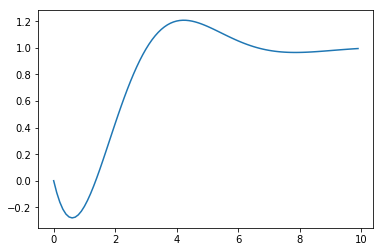

In [6]:
#test step
G_n= tf2ss(b=SX([-1, 1]), a=SX([1,1,1]))
step(G_n,dt=0.1,tf=10)


## PI and PID tranfer function
$$PI \Rightarrow Kp+\frac{Ki}{s}=\frac{sKp+Ki}{s}$$
$$PID \Rightarrow Kp+\frac{Ki}{s}+Kd\frac{s}{\alpha s+1} = \frac{Kd(1+\alpha Kp)s^2+(Kp+\alpha Ki Kd)s+Ki}{\alpha Kd s^2+s}$$

In [7]:
def pi(pc):
    """Creates PI controller from parameters in paralell form (Kp + Ki/s).

    Parameters
    ----------
    param1 : pc
        List of parameters: Kp, proportional gain, and Ki, integral gain.
        
    Returns
    -------
    ss
        Namedtuple wiht A, B, C and D matrix of state space controller
    """
    kp,ki = pc[0],pc[1]
    return tf2ss(vertcat(kp,ki),
                 vertcat(SX(1),SX(1,1)));

def pid(pc,alpha=0.1):
    """Creates PID controller from parameters (Kp+Ki/s+Kd*s/(alpha*s+1)).

    Parameters
    ----------
    param1 : pc
        List of parameters: Kp, proportional gain; Ki, integral gain;
        and Kd, derivative gain.
    param2 : alpha
        Derivative filter factor
        
    Returns
    -------
    ss
        Namedtuple wiht A, B, C and D matrix of state space controller
    """
    kp,ki,kd = pc[0],pc[1],pc[2]
    return tf2ss(vertcat(kd*(1+alpha*kp),kp+alpha*ki*kd,ki),
                 vertcat(alpha*kd,1,SX(1,1)))

In [8]:
C = pid(DM([0.3,0.3,0.01]))
print(C)

ss(A=SX(
[[00, 1], 
 [00, -1000]]), B=SX([00, 1]), C=SX([[300, -9999.7]]), D=SX(10.3))


## System transformation

### Series

Plant:

\begin{eqnarray}
\dot{x}	& = & Ax + Bu \\
y 		& = & Cx + Du
\end{eqnarray}

Controller:
\begin{eqnarray}
\dot{z}	& = & \tilde{A}z + \tilde{B}e  \\
u 		& = & \tilde{C}z + \tilde{D}e 
\end{eqnarray}

Serie:
\begin{equation}\begin{aligned}
\begin{bmatrix}\dot{x}\\\dot{z}\end{bmatrix} & = \begin{bmatrix} A  & B\tilde{C} \\ 0 & \tilde{A} \end{bmatrix}\begin{bmatrix}x \\ z\end{bmatrix} + \begin{bmatrix} B\tilde{D} \\ \tilde{B}\end{bmatrix}e\\
y & =  \begin{bmatrix}C & D\tilde{C}\end{bmatrix}\begin{bmatrix}x \\ z\end{bmatrix}+D\tilde{D}e
\end{aligned}\end{equation}


In [9]:
def series(G,C):
    """Computes the series system (GC) of Plant (G) and Controller (C),
    all in state space form.

    Parameters
    ----------
    param1 : G
        Plant in state space form
    param2 : C
        Controller in state space form
        
    Returns
    -------
    ss
        Resultant series system, in open loop.
    """
    return ss(vertcat(horzcat(G.A,G.B@C.C),
                      horzcat(SX(C.A.shape[0], G.A.shape[0]),C.A)),
              vertcat(G.B@C.D,C.B),
              horzcat(G.C,G.D@C.C),
              G.D@C.D)



### Feedback

Open-loop:
\begin{eqnarray}
\dot{x}	& = & Ax + Be \\
y 		& = & Cx + De
\end{eqnarray}

Doing:
$$e = r-y$$
$$F = (I+D)^{-1}$$

Close loop:
\begin{eqnarray}
\dot{x}	& = & (A-BFC)x + (BF)r \\
y 		& = & (C-DFC)x + (DF)r
\end{eqnarray}

In [10]:
def feedback(G,C):
    """Computes the feebback system (inv(I+GC)GC) of Plant and Controller,
    all in state space form.

    Parameters
    ----------
    param1 : G
        Plant in state space form
    param2 : C
        Controller in state space form
        
    Returns
    -------
    ss
        Resultant feedback system, in open loop.
    """
    A,B,C,D = series(G,C)
    F = inv(SX.eye(D.shape[0])+D)
    return ss(A-B@F@C,B@F,C-D@F@C,D@F)

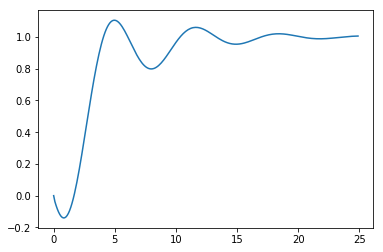

In [11]:
T = feedback(G_n,C)
step(T,25)

# ISE Tunning

### Transform to $\dot{r}-e$ form

The H2 norm of the system in form $\dot{r}-e$ is the ISE for the unitary step scenario of the original system. That is why it is so important.

\begin{eqnarray}
\dot{x}	& = & Ax + Br \\
y 		& = & Cx + Dr
\end{eqnarray}

assuming $y = r$ in steady state and doing $w = \dot{x}$:

\begin{equation}\begin{aligned}
\dot{w}	& = & Aw + B\dot{r}  \\
e 		& = & -CA^{-1}w
\end{aligned}
\end{equation}

In [12]:
def transform(T):
    """Converts a system from 'r-y' form to 'dr-e' form.

    Parameters
    ----------
    param1 : T
        Feedback state space system  in 'r-y' form, that is,
        the reference as input and the controlable variables as output.
        
    Returns
    -------
    ss
        Feedback state space system  in 'dr-e' form: the time derivative
        of reference as input and the follow-up error as output.
    """
    A,B,C,D = T
    return ss(A,B,-C@inv(A),SX(*D.shape))

## Analytical ISE calculation 

### H2 norm calculation

Be a system $G$ given by this state space equations:

\begin{equation}\begin{aligned}
\dot{x}	& = & Ax + Bu  \\
y 		& = & Cx + Du
\end{aligned}
\end{equation}

Its H2 norm, assuming it is finite, can be calculated by the following equation:

\begin{equation}
\Vert G\Vert_2^2 =  \text{tr}(P) 
\end{equation}

\begin{equation}
P = CQC^\top + DD^\top
\end{equation}

\begin{equation}
AQ+QA^\top+BB^\top=0\\
\end{equation}

\begin{equation}
(I_n\otimes A+A^\top\otimes I_n)vec(Q) = -vec(BB^\top)
\end{equation}

In [13]:
def h2norm(G):
    """Calculates the H2 norm of a system in state space form,
    assuming it is finite.

    Parameters
    ----------
    param1 : G
        System in state space form
        
    Returns
    -------
    float
        H2 norm. If H2 norm is not finite, this value has no meaning.
    """
    A,B,C,D = G
    nx,nu = B.shape
    ny,nu = D.shape
    Q = reshape(solve(kron(SX.eye(nx),A)+kron(A,SX.eye(nx)),
                      -vec(B@B.T)),nx,nx)
    P = C@Q@C.T + D@D.T
    return trace(P)

def ISE(G,C=None):
    """Calculates analytical ISE of a MIMO state space system for a
    scenario of unit steps in the input.
    
    Uses the 'dr-e' form of the system, whose H2 norm is the desired ISE.

    Parameters
    ----------
    param1 : G
        System in state space form. If no controller provided, 
        it is assumed that it its already in feedback.
    param2 : C
        Controller in state space form.
    
    Returns
    -------
    float
        ISE. If ISE is infinite, this value has no meaning.
    """
    if not C is None: G = feedback(G,C)
    return h2norm(transform(G))

def stable(G,C=None):
    """Test stability of feedback system, using eigvalues test.

    Parameters
    ----------
    param1 : G
        System in state space form. If no controller provided, 
        it is assumed that it its already in feedback.
    param2 : C
        Controller in state space form.
    
    Returns
    -------
    bool
        True if the system is stable.
    """
    if not C is None: G = feedback(G,C)
    return np.all(np.real(np.linalg.eigvals(SX2DM(G.A)))< 0) 
    

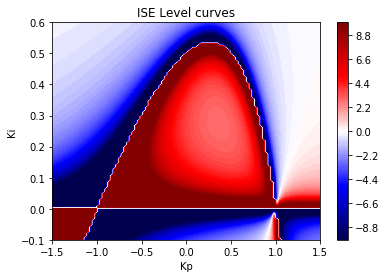

In [14]:
#plot ISE contour varying Kp and Ki PI controller parameters
pc = SX.sym('pc',2)
fISE = Function('fISE',[pc],[ISE(G_n,pi(pc))],['pc'],['ISE'])
f = lambda x: max(min(x,10),-10) # function to limitate the output 

N = 100
kps, kis = np.linspace(-1.5, 1.5, N), np.linspace(-.1, .6, N) 
ISEs = np.array([[f(fISE([kp,ki])) for kp in kps] for ki in kis])

plt.contourf(kps,kis,ISEs,100,cmap=plt.cm.seismic),plt.colorbar()
plt.title('ISE Level curves'),plt.xlabel('Kp'),plt.ylabel('Ki')
plt.show()

## Minimize ISE

In [15]:
opts = {'print_time':0,
        'ipopt':{'max_iter':100,'tol':1e-3,'print_level':0,'sb':'yes'}}

def minise(G,C,pc,pc0,pc_min,pc_max):
    """ise tunning. Find parameters of controller that minimize ISE
    of feedback system.

    Parameters
    ----------
    param1 : G
        Plant in state space form.
    param2 : C
        Controller in state space form.
    param2 : pc
        Symbolic controller parameters.
    param2 : pc0
        Initial .
    param2 : pc_min
        Controller parameters lower bound for optimization.
    param2 : pc_max
        Controller parameters upper bound for optimization.
    
    Returns
    -------
    dict
        'pc': optimal controller parameters, 'f': optimal ISE
    """
    res = nlpsol('S','ipopt',{'x':pc,'f':ISE(G,C),'g':pc},opts) \
            (x0=pc0,lbg=pc_min,ubg=pc_max)
    return {'pc':res['x'],'f':res['f']}


PI ótimo: [0.366928, 0.27466] 
PID ótimo: [0.457461, 0.48866, 0.47924]


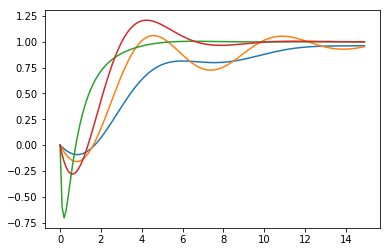

In [16]:
# Test PI ise tunning
pc,pc0,pc_min,pc_max = SX.sym('pc',2),DM([.2,.2]),DM([.1,.1]),DM([1.,1.])
res_pi = minise(G_n,pi(pc),pc,pc0,pc_min,pc_max)
# Test PID ise tunning
pc,pc0 = SX.sym('pc',3),DM([.3,.3,.3])
pc_min,pc_max = DM([.1,.1,.1]),DM([1.,1.,1.])
res_pid = minise(G_n,pid(pc),pc,pc0,pc_min,pc_max)
print('PI ótimo:',res_pi['pc'],'\nPID ótimo:',res_pid['pc'])

#Systems to plot
Ts = [feedback(G_n,pi([0.2,0.2])),
      feedback(G_n,pi(res_pi['pc'])),
      feedback(G_n,pid(res_pid['pc'])),
      G_n]
ISEs = [SX2DM(ISE(T)).full()[0,0] for T in Ts]
step(Ts,tf=15)

In [17]:
def sensitivity(f,x,dx=0.1,N=10):
    """Sensitivity analysis in function for each parameter.

    Parameters
    ----------
    param1 : f
        Function that receives a vector and return a number.
    param2 : x
        Point around which the sensitivity analysis will be performed.
    param3 : dx
        Number that especifies of change in the parameters.
    param4 : N
        Number of points to evaluate the function in both sides.
    """
    x = np.ravel(x)
    Mdx = np.diag(dx*x) #create matrix of changes in each parameter
    t = range(-N,N+1)
    y = np.array([[f(x+Mdx[i]*j/N) for j in t] for i in range(len(x))])  
    plt.plot(t,y.T)
    percentage = '{:.2f}%'.format(100*dx)
    plt.xticks((-N, N),('-'+percentage, percentage)
    plt.xlabel('Percentage of parameter change')
    plt.show()

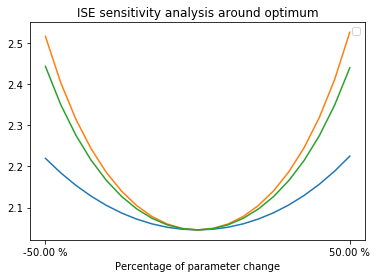

Autovalores da Hessiana no ponto ótimo: [ 17.263   6.698   4.867]
Gradiente no ponto ótimo: [ 0.  0.  0.]


In [18]:
# Apply sensitivity analysis to ISE around optimum PID controler
f = Function('f',[pc],[ISE(G_n,pid(pc))],['pc'],['ISE'])
plt.legend(['Kp','Ki','Kd'])
plt.title('ISE sensitivity analysis around optimum')
sensitivity(f,res_pid['pc'],0.5)
[H, g] = substitute(hessian(ISE(G_n,pid(pc)),pc),[pc],[res_pid['pc']])
print('Hessian eigen values:', np.linalg.eigvals(SX2DM(H)))
print('Gradient:', SX2DM(g).full().flatten())

# EISE Tunning

## Sensitivity system

Given $G=(A(p),B(p),C(p),D(p))$, a state space model depending on parameter vector $p$:

\begin{eqnarray}
\dot{x}	& = & A(p)x + B(p)u \\
y 		& = & C(p)x + D(p)u
\end{eqnarray}

We define ${\partial G}/{\partial p_i}$, the associeted sensitivity system in relation to parameter $p_i$, as:

\begin{eqnarray}
\frac{\partial \dot{x}}{\partial p}	& = & \frac{\partial A}{\partial p}x +A \frac{\partial x}{\partial p} + \frac{\partial B}{\partial p} u \\
\frac{\partial y}{\partial p}	& = & \frac{\partial C}{\partial p}x +C \frac{\partial x}{\partial p} + \frac{\partial D}{\partial p} u \\
\end{eqnarray}

In [19]:
def sensys(G,p,p_n,i):
    """Calculates the state space sensitivity system of model.

    Parameters
    ----------
    param1 : G
        Mode in state space form.
    param2 : p
        Simbolic parameters of model.
    param3 : p_n
        Value of parameters.
    param4 : i
        Parameter inded for which sensitivity system will be calculated.
    
    Returns
    -------
    ss
        State space sensibility system in relation to parameter p_i
    """
    nx = G.A.shape[0]
    ny,nu = G.D.shape
    A = vertcat(horzcat(G.A,SX(nx,nx)),
                horzcat(reshape(jacobian(G.A,p[i]),nx,nx),G.A))
    B = vertcat(G.B,reshape(jacobian(G.B,p[i]),nx,nu))
    C = horzcat(reshape(jacobian(G.C,p[i]),ny,nx),G.C)
    D = reshape(jacobian(G.D,p[i]),ny,nu)
    return ss(*substitute([A,B,C,D],[p],[p_n]))

## Output covariance in flunction of Parameters covariance

Using uncertainty propagation, the variance of output, $\sigma_y^2$, can be calculated in function of output sentivity in relation to parameters, ${\partial y}/{\partial p}$, and covariance matrix of parameters, $\sigma_p^2$, using the following equation:

\begin{equation}
\sigma_y^2 = \left(\frac{\partial y}{\partial p}\right)\sigma_p^2\left(\frac{\partial y}{\partial p}\right)^\top
\end{equation}

In [20]:
def step_inc(Gs,p,p_n,V,tf,dt=0.1):
    """Plot step of system together with associeted uncertainty.
    Uses analytical propagation of parameters covariance matrix.

    Parameters
    ----------
    param1 : Gs
        List of models in state space form.
    param2 : p
        Simbolic parameters of models.
    param3 : p_n
        Value of parameters.
    param4 : V
        Covariance matrix of parameters.
    param5 : tf
        End time of simulation.
    param6 : dt
        Time step.
    """
    if isinstance(Gs, ss): Gs = [Gs]
    ny,nu = Gs[0].D.shape     
    fig,axes = plt.subplots(ny, nu,
                   sharex='col', sharey='row', squeeze=False)
    # Loop in the systems and system colors
    for G,color in zip(Gs,plt.rcParams['axes.prop_cycle']): 
        ys, ts =  step([ss(*substitute(G,[p],[p_n]))],tf,dt,plot=False)
        ys = ys[0]
        nk = len(ts)
        dydp = step([sensys(G,p,p_n,i) for i in range(p.shape[0])]
                    ,tf,dt,plot=False)[0]
        sig_ys=np.sqrt(np.array([[[dydp[:,i,j,k].dot(V@dydp[:,i,j,k])[0]
            for k in range(nk)] for j in range(nu)] for i in range(ny)]))
        for i,row in enumerate(axes):
            for j,ax in enumerate(row):
                ax.plot(ts,ys[i,j],
                        ts,ys[i,j]+sig_ys[i,j],':',
                        ts,ys[i,j]-sig_ys[i,j],':',**color)
        

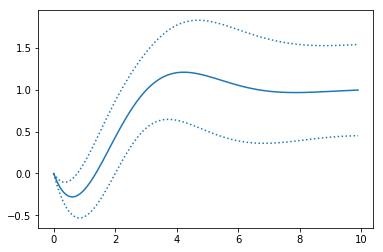

In [21]:
#test step_inc
p,p_n = SX.sym('p',4),DM([-1,1,1,1])
V = 0.16*DM([[1,.5,0,0],[.5,1,.5,0],[0,.5,1,.5],[0,0,.5,1]])
G = tf2ss(SX(p[:2]),SX(vertcat(1,p[2:])))
step_inc([G],p,p_n,V,tf=10)

## Ortonormal parametrization

Be $\sigma_p^2 = UDU^\top$ the singular value decomposition of $\sigma_p^2$, covariance matrix of parameter vetor $p$. I we do a coordinates change $q = D^{-1/2}U^\top p$, the parameters $q$ in the coodinates has identity covariance matrix.

In [22]:
def reparam(G,p,V):
    """Convert system parameters to a ortonormal parameters.

    Parameters
    ----------
    param1 : G
        System in state space form.
    param2 : p
        Simbolic parameters of system.
    param3 : V
        Covariance matrix of parameters
    
    Returns
    -------
    ss
        System reparameterizided
    SX
        New parameters for the system 
    numpy.array
        Matrix to convert beetween parametrizations: p = sV@q 
    """
    w,v = np.linalg.eig(np.array(V))
    sV = v@np.diag(np.sqrt(w))
    q = SX.sym('q',p.shape[0])

    return ss(*substitute(G,[p],[sV@q])),q,sV

## EISE calculation

Suposing we have ortonormal parametrization, the EISE, expectation of ISE, can be calculated as follows:

\begin{equation}\begin{aligned}
EISE & = E\left( ISE \right) = E \left( \sum_i\sum_j\int_0^\infty e^2_{ij}(t)dt \right) = \sum_i\sum_j\int_0^\infty E(e^2_{ij}(t))dt = \\
& = \sum_i\sum_j\int_0^\infty E(e_{ij}(t))^2+VAR(e_{ij}(t))dt= \\
&= \sum_i\sum_j\int_0^\infty E(e_{ij}(t))^2 dt+\sum_i\sum_j\int_0^\infty VAR(e_{ij}(t))dt = \\
& = \sum_i\sum_j\int_0^\infty E(e_{ij}(t))^2 dt+\sum_i\sum_j\int_0^\infty \sum_k  \left(
\frac{\partial e_{ij}}{\partial p_k} \right)^2 dt = \\
& = \sum_i\sum_j\int_0^\infty E(e_{ij}(t))^2 dt+\sum_k \left( \sum_i\sum_j\int_0^\infty   \left(
\frac{\partial e_{ij}}{\partial p_k} \right)^2 dt \right) = \\
&=\left\Vert G \right\Vert_2^2 + \sum_k \left\Vert \frac{\partial G}{\partial p_k} \right\Vert_2^2  = ISE + IVE
\end{aligned}\end{equation}

In [23]:
def EISE(G,p,p_n,V,C):
    """Calculates EISE (Expected ISE) of a pair plant-controller.

    Parameters
    ----------
    param1 : G
        System in state space form.
    param2 : p
        Simbolic parameters of system.
    param3 : p_n
        Value of parameters of system.
    param4 : V
        Covariance matrix of parameters
    param5 : C
        Controler in state space form
    
    Returns
    -------
    float
        EISE value
    """
    T,q,sV = reparam(feedback(G,C),p,V) #p = sV*q
    q_n = inv(sV)@p_n
    Tt = transform(T)
    return h2norm(ss(*substitute(Tt,[q],[q_n]))) + \
            sum(h2norm(sensys(Tt,q,q_n,i)) for i in range(q.shape[0]))

def mineise(G,p,p_n,V,C,pc,pc0,pc_min,pc_max):
    """eise tunning. Find parameters of controller that minimize EISE
    of feedback system.

    Parameters
    ----------
    param1 : G
        Plant in state space form.
    param2 : p
        Simboli plant parameters.
    param3 : p_n
        Value of plant parameters.
    param4 : V
        Covariance matrix of plant parameters
    param2 : C
        Controller in state space form.
    param2 : pc
        Symbolic controller parameters.
    param2 : pc0
        Initial guess for controller parameters.
    param2 : pc_min
        Controller parameters lower bound for optimization.
    param2 : pc_max
        Controller parameters upper bound for optimization.
    
    Returns
    -------
    dict
        'pc': optimal controller parameters, 'f': optimal EISE
    """
    res = nlpsol('S','ipopt',{'x':pc,'f':EISE(G,p,p_n,V,C),'g':pc},opts)\
            (x0=pc0,lbg=pc_min,ubg=pc_max)
    return {'pc':res['x'], 'f':res['f']}

PI EISE ótimo: [0.292405, 0.231803]
PID EISE ótimo: [0.400762, 0.418714, 0.443431]


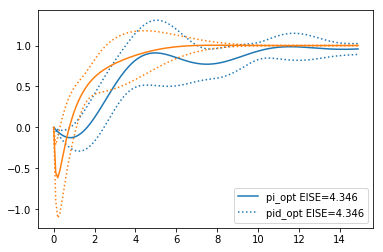

In [24]:
#test eise tunning
p,p_n = SX.sym('p',4),DM([-1,1,1,1])
V = 0.16*DM([[1,.5,0,0],[.5,1,.5,0],[0,.5,1,.5],[0,0,.5,1]])
G = tf2ss(SX(p[:2]),SX(vertcat(1,p[2:])))
pc,pc0,pc_min,pc_max = SX.sym('pc',2),DM([.2,.2]),DM([.1,.1]),DM([1.,1.])
res_pi = mineise(G,p,p_n,V,pi(pc),pc,pc0,pc_min,pc_max)
pc,pc0 = SX.sym('pc',3),DM([.3,.3,.3])
pc_min,pc_max = DM([.1,.1,.1]),DM([1.,1.,1.])
res_pid = mineise(G,p,p_n,V,pid(pc),pc,pc0,pc_min,pc_max)
print('PI EISE ótimo:',res_pi['pc'])
print('PID EISE ótimo:',res_pid['pc'])
Cs = [pi(res_pi['pc']),pid(res_pid['pc'])]
EISEs = [SX2DM(EISE(G,p,p_n,V,C)).full()[0,0] for T in Ts]
step_inc([feedback(G,C) for C in Cs],p,p_n,V,tf=15) 
plt.legend(['{} EISE={:.4}'.format(*x)
            for x in zip(['pi_opt','pid_opt'],EISEs)])    
plt.show()

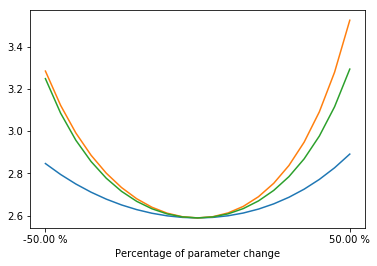

Autovalores da Hessiana no ponto ótimo: [ 34.833  12.869   9.791]
Gradiente no ponto ótimo: [  1.515e-05   1.249e-05   1.083e-05]


In [25]:
# Apply sensitivity analysis to EISE around optimum PID controler
eise = EISE(G,p,p_n,V,pid(pc))
f = Function('f',[pc],[eise],['pc'],['ISE'])
sensitivity(f,res_pid['pc'],0.5)
[H, g] = substitute(hessian(eise,pc),[pc],[res_pid['pc']])
print('Hessian eigen values:', np.linalg.eigvals(SX2DM(H)))
print('Gradient:', SX2DM(g).full().flatten())

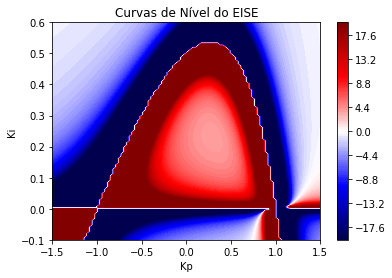

In [26]:
#plot EISE contour varying Kp and Ki PI controller parameters
pc = SX.sym('pc',2)
fEISE = Function('fEISE',[pc],[EISE(G,p,p_n,V,pi(pc))],['pc'],['EISE'])
f = lambda x: max(min(x,20),-20) # function to limitate the output 

N = 100
kps, kis = np.linspace(-1.5, 1.5, N), np.linspace(-.1, .6, N) 
EISEs = np.array([[f(fEISE([kp,ki])) for kp in kps] for ki in kis])

plt.contourf(kps,kis,EISEs,100,cmap=plt.cm.seismic),plt.colorbar()
plt.title('Curvas de Nível do EISE'),plt.xlabel('Kp'),plt.ylabel('Ki')
plt.show()

In [27]:
def worstcase(G,p,p_n,V,n_ic,C,p0=None):
    """Calculates the worst case plant for the controller considering
    a uncertain region on plant G. 

    Parameters
    ----------
    param1 : G
        Plant in state space form.
    param2 : p
        Symbolic plant parameters.
    param3 : p_n
        Value of plant parameters.
    param4 : V
        Covariance matrix of plant parameters.
    param5 : C
        Controller in state space form.
    param6 : p0
        Initial guess for parameters of worst case plant.
    
    Returns
    -------
    dict
        'p': worst case plant parameters, 'f': worst case ISE,
        'lambda': associated Lagrange multipliers
    """
    if p0 is None: p0 = 1.1*p_n
    p0 = p_n + (p0-p_n)*(n_ic/sqrt((p0-p_n).T@inv(V)@(p0-p_n)))   
    mahalanobis = (p-p_n).T@inv(V)@(p-p_n)
    nlp = {'x':p,'f':-ISE(G,C),'g':mahalanobis}
    res = nlpsol('S','ipopt',nlp,opts)(x0=p0,lbg=n_ic**2,ubg=n_ic**2)
    return {'p':res['x'], 'f':-res['f'], 'lambda':-res['lam_g']}

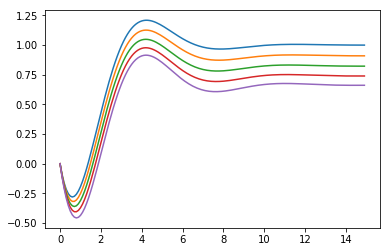

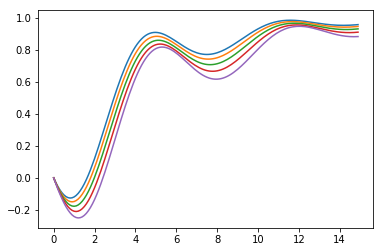

In [28]:
n_ics = np.arange(0,1.0,0.2)
w_cases = [worstcase(G,p,p_n,V,n_ic,pi(res_pi['pc'])) for n_ic in n_ics]

tf,dt = 15,0.1
step([ss(*substitute(G,[p],[w_case['p']])) for w_case in w_cases],tf,dt)
step([feedback(ss(*substitute(G,[p],[w_case['p']])),
               pi(res_pi['pc'])) for w_case in w_cases],tf,dt)

## Min-max formulation

\begin{equation}
\min_{\mathbf{C}} \max_{\mathbf{G}} ISE(\mathbf{C},\mathbf{G})
\end{equation}

Using KKT first order necessary conditions:

\begin{equation}\begin{aligned}
\min_{\mathbf{C},\mathbf{G},\lambda} & ISE(\mathbf{C},\mathbf{G}) \\
\text{s.a.} & \frac{\partial ISE(\mathbf{C},\mathbf{G})}{\partial \mathbf{G}}+\lambda \frac{\partial D_M(\mathbf{G})}{\partial \mathbf{G}} = 0 \\
 & D_M(\mathbf{G}) - n_\sigma = 0
\end{aligned}\end{equation}

In [29]:
def minmax(G,p,p_n,V,n_ic,C,pc,pc0):
    """minmax tunning, finds the controller parameters that minimize
    the worst case inside a confidence region. 

    Parameters
    ----------
    param1 : G
        Plant in state space form.
    param2 : p
        Symbolic plant parameters.
    param3 : p_n
        Value of plant parameters.
    param4 : V
        Covariance matrix of plant parameters.
    param5 : C
        Controller in state space form.
    param6 : pc
        Symbolic controller parameters.
    param7 : pc0
        Initial guess for controller parameters.
    
    Returns
    -------
    dict
        'p': worst case plant parameters, 'f': worst case ISE,
        'pc': optimum controler parameters
    """
    w_case = worstcase(G,p,p_n,V,n_ic,ss(*substitute(C,[pc],[pc0])))
    lambd = SX.sym('lambd')
    mahalanobis = (p-p_n).T@inv(V)@(p-p_n)
    ise = ISE(T)
    kkt = jacobian(ise,p)+lambd*jacobian(mahalanobis,p)
    nlp = {'x':vertcat(p,pc,lambd),'f':-ise,
           'g':vertcat(mahalanobis,kkt.T)} 
    bg = vertcat(n_ic**2,DM(p.shape[0],1))
    res = nlpsol('S','ipopt',nlp,opts) \
        (x0=vertcat(w_case['p'],pc0,w_case['lambda']),lbg=bg,ubg=bg)
    n_p = p.shape[0]
    return {'p':res['x'][:n_p],'pc':res['x'][n_p:],'f':-res['f']}

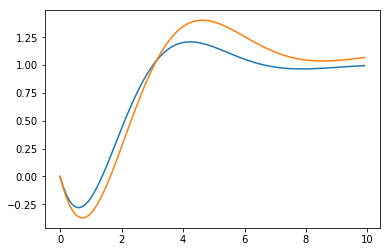

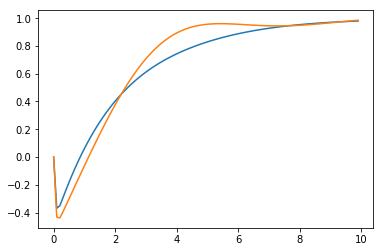

In [30]:
#test minmax tunning
pc,pc0 = SX.sym('pc',3),DM([.3,.3,.3])
pc_min,pc_max = DM([.1,.1,.1]),DM([1.,1.,1.])
n_ic=0.6
res = minmax(G,p,p_n,V,n_ic,C,pc,pc0)
G_pior = ss(*substitute(G,[p],[res['p']]))
#step of open loop nominal model and worst case plant
step([G_n,G_pior],10)
#step of close loop nominal model and worst case plant
step([feedback(G_n,pid(res['pc'])), feedback(G_pior,pid(res['pc']))],10)

# ISE restricted optimization

### Complex determinant

Be a complex matrix $L$, for which we want to compute determinant.

\begin{equation}\begin{aligned}
L = L^0+jL^1 \\
L = \begin{bmatrix}L_1 & L_2 & \cdots & L_n\end{bmatrix} \\
L^0 = \begin{bmatrix}L^0_1 & L^0_2 & \cdots & L^0_n\end{bmatrix} \\
L^1 = \begin{bmatrix}L^1_1 & L^1_2 & \cdots & L^1_n\end{bmatrix} \\
\end{aligned}\end{equation}

We have:

\begin{equation}
det(L) = \sum_{x \in \{0,1\}^n}det(\begin{bmatrix}L^{x_1}_1 & L^{x_2}_2 & \cdots & L^{x_n}_n\end{bmatrix})
\end{equation}

In [32]:
from itertools import product
def complexdet(A,B):
    """Computes de determinant of the complex matrix A+jB. 

    Parameters
    ----------
    param1 : A
        Real part of matrix.
    param2 : B
        Imaginary part of matrix.
    
    Returns
    -------
    SX
        Symbolic array with two values: real and imag part of determinant.
    """
    n = A.shape[0]
    M = horzcat(A,B)
    C,D = 0,0
    for i in product([0,1],repeat=n):
        d = det(M[:,np.arange(n)+n*np.array(i)])
        if sum(i)%4 == 0: C += d
        if sum(i)%4 == 1: D += d
        if sum(i)%4 == 2: C -= d
        if sum(i)%4 == 3: D -= d
    return vertcat(C,D)

In [33]:
#test det(A+jB)
print(complexdet(SX.sym('A',2,2),SX.sym('B',2,2)))

[(((A_0*A_3)-(A_2*A_1))-((B_0*B_3)-(B_2*B_1))), (((A_0*B_3)-(B_2*A_1))+((B_0*A_3)-(A_2*B_1)))]


Be $L=(A,B,C,D)$ a open loop state space system. We have frequency response $G(j\omega)$: $$L(j\omega)=-C(\omega^2 I+A^2)^{-1}AB+ D - j\omega C(\omega^2 I+A^2)^{-1}B$$
The Nyquist diagram is the plot for $\omega$ varying beetween $-\infty$ and $+\infty$ of the function: $$det(I+L(j\omega))$$

In [34]:
def nyquist(L,w):
    """finds det(I+L(j*omega)) to plot Nyquist diagram. 

    Parameters
    ----------
    param1 : L
        Open loop in state space form. Plant in series
    param2 : w
        Frequency.
    
    Returns
    -------
    SX
        Real and imaginary parts of point in Nyquist diagram.
    """
    A,B,C,D = L
    M = inv(w**2*SX.eye(A.shape[0])+A@A)
    return complexdet(-C@A@M@B+D+SX.eye(D.shape[0]), -w*C@M@B)

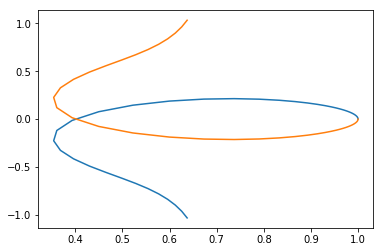

In [35]:
#test nyquist
ws = np.logspace(-.5,3,100)
rfs = [nyquist(series(G_n,pi(pc0)),w) for w in ws]
re,im = zip(*((rf[0],rf[1]) for rf in rfs))
plt.plot(re,im)
plt.plot(re,-np.array(im))
plt.show()

##  Controller robustiness rate

Defining $N(\mathbf{C},\mathbf{G},\omega)$:
\begin{equation}
N(\mathbf{C},\mathbf{G},\omega) = \begin{bmatrix}Re(det(I+\mathbf{G}(j\omega)\mathbf{C}(j\omega))) \\ Im(det(I+\mathbf{G}(j\omega)\mathbf{C}(j\omega))) \end{bmatrix}    
\end{equation}

The condition $N(\mathbf{C},\mathbf{G},\omega) = 0 $ is equivalent to the system be marginally stable. So we define robustiness rate as:  

\begin{equation}\begin{aligned}
rate(\mathbf{C}) = \min_G D_M(\mathbf{G}) \\
\text{subject to} \: N(\mathbf{C},\mathbf{G},\omega) = 0
\end{aligned}\end{equation}

In [36]:
def rate(G,p,p_n,V,C):
    """Calculates the controler robustness rate. 

    Parameters
    ----------
    param1 : G
        Plant in state space form.
    param2 : p
        Symbolic plant parameters.
    param3 : p_n
        Value of plant parameters.
    param4 : V
        Covariance matrix of plant parameters.
    param5 : C
        Controller in state space form.
    
    Returns
    -------
    dict
        'rate': controller robustness rate, 'p': destabilizer plant,
        'w': unstable frequency, 'lambda': Lagrange multiplier 
    """
    mahalanobis = (p-p_n).T@inv(V)@(p-p_n)
    ln_w = SX.sym('ln_w')
    nlp = {'x':vertcat(p,ln_w),'f':mahalanobis,
           'g':nyquist(series(G,C),exp(ln_w))}
    res =  nlpsol('S','ipopt',nlp,opts) \
                 (x0=vertcat(p_n*1.1,0),lbg=[0,0],ubg=[0,0])
    return {'rate':sqrt(res['f']),'lambda':res['lam_g'],
            'p':res['x'][:-1],'w':exp(res['x'][-1])}


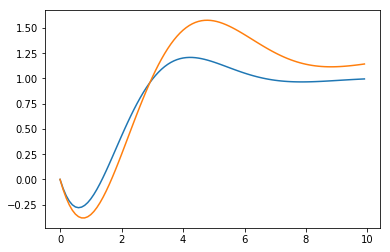

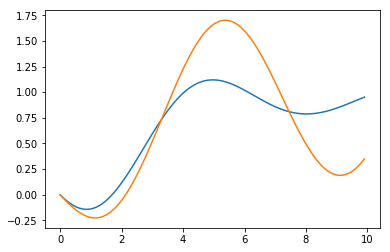

In [37]:
#test rate
C = pi([.3,.3])
res = rate(G,p,p_n,V,C)

step([G_n,ss(*substitute(G,[p],[res['p']]))],10)
step([feedback(G_n,C),feedback(ss(*substitute(G,[p],[res['p']])),C)],10)


## iseres tunning

\begin{equation}\begin{aligned}
\min_\mathbf{C} ISE(\bar{\mathbf{G}},\mathbf{C}) \\
\text{subject to} \: \text{rate}(\mathbf{C}) \geq n_\sigma
\end{aligned}\end{equation}

Can be rewritten as:

\begin{equation}\begin{aligned}
\min_{\mathbf{C},\mathbf{G},\omega,\lambda} & ISE(\mathbf{C},\bar{\mathbf{G}}) \\
\text{subject to} \; & D_M(\mathbf{G}) = n_\sigma \\
& \frac{\partial D_M(\mathbf{G})}{\partial \mathbf{G}} + \lambda^\top \frac{\partial N(\mathbf{C},\mathbf{G},\omega)}{\partial \mathbf{G}} = 0 \\
& \lambda^\top\frac{\partial N(\mathbf{C},\mathbf{G},\omega)}{\partial \omega} = 0 \\
& N(\mathbf{C},\mathbf{G},\omega) = 0\\
\end{aligned}\end{equation}

In [38]:
def iseres(G,p,p_n,V,n_ic,C,pc,pc0):
    """iseres tunning. Find optimal control parameters that minimize ISE
    while keeping a minimum robustness rate.  

    Parameters
    ----------
    param1 : G
        Plant in state space form.
    param2 : p
        Symbolic plant parameters.
    param3 : p_n
        Value of plant parameters.
    param4 : V
        Covariance matrix of plant parameters.
    param5 : n_ic
        Size of confidence interval, in number of standard deviations.
    param6 : C
        Controller in state space form.
    param7 : pc
        Symbolic controller parameters.
    param8 : pc0
        Initial guess for controller parameters.
    
    Returns
    -------
    dict
        'pc': optimum controller parameters, 'p': destabilizer plant,
        'f': ISE of controller
    """
    res = rate(G,p,p_n,V,ss(*substitute(C,[pc],[pc0])))
    ise = ISE(ss(*substitute(G,[p],[p_n])),C)
    mahalanobis = (p-p_n).T@inv(V)@(p-p_n)
    ln_w = SX.sym('ln_w')
    N = nyquist(series(G,C),exp(ln_w))
    lambd = SX.sym('lambd',2)
    nlp = {'x':vertcat(p,pc,ln_w,lambd),'f':ise,
           'g':vertcat(mahalanobis-n_ic**2,
                       (jacobian(mahalanobis,p)+lambd.T@jacobian(N,p)).T,
                       lambd.T@jacobian(N,ln_w),N)} 
    bg = DM(p.shape[0]+4,1)
    x0=vertcat(res['p'],pc0,log(res['w']),res['lambda'])
    res = nlpsol('S','ipopt',nlp,opts)(x0=x0,lbg=bg,ubg=bg)
    n_p,n_pc = p.shape[0],pc.shape[0]
    return {'p':res['x'][:n_p], 'pc':res['x'][n_p:n_p+n_pc],'f':res['f']}



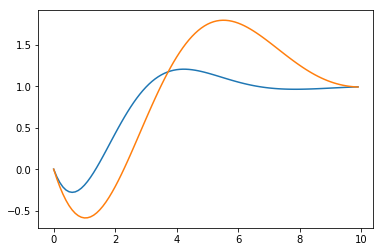

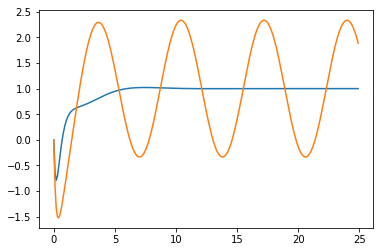

In [39]:
#test iseres
pc,pc0 = SX.sym('pc',3),DM([.3,.3,.3])
pc_min,pc_max = DM([.1,.1,.1]),DM([1.,1.,1.])
C = pid(pc)
n_ic = 1.5
res = iseres(G,p,p_n,V,n_ic,C,pc,pc0)
G_inst = ss(*substitute(G,[p],[res['p']]))
step([G_n,G_inst],10)
step([feedback(G_n,pid(res['pc'])),feedback(G_inst,pid(res['pc']))],25)